In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log

In [21]:
log_file = "../../backtests/test.log"
trader_data, products_data, activities, trades = process_log(log_file)

In [22]:
PRODUCT = "KELP"
product_data = products_data[PRODUCT]
activities = activities[activities["product"] == PRODUCT].reset_index()

KeyError: 'KELP'

In [23]:
price = product_data["current_price"]

bp1 = activities["bid_price_1"]
bv1 = activities["bid_volume_1"]
bp2 = activities["bid_price_2"]
bv2 = activities["bid_volume_2"]
bp3 = activities["bid_price_3"]
bv3 = activities["bid_volume_3"]

ap1 = activities["ask_price_1"]
av1 = activities["ask_volume_1"]
ap2 = activities["ask_price_2"]
av2 = activities["ask_volume_2"]
ap3 = activities["ask_price_3"]
av3 = activities["ask_volume_3"]

<Axes: >

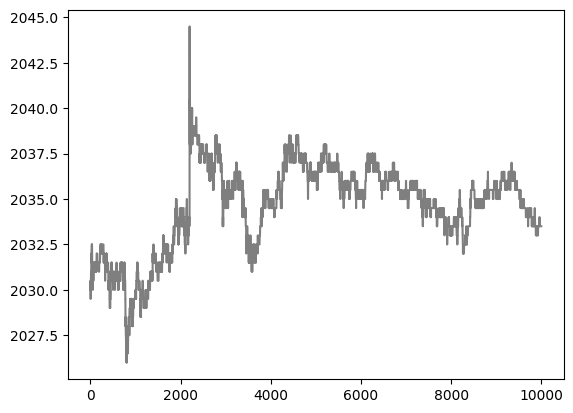

In [24]:
price.plot(label="Price", color="black", alpha=0.5)

/var/folders/4_/nj45w49n4nq1x2nm00vm98dw0000gn/T/ipykernel_47532/3893200743.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2030.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[current_idx, 'bid_price_1'] = exit_price


Total Trades: 35
Winning Trades: 23 (65.71%)
Losing Trades: 8
Total P&L: -86750.50
Average P&L per Trade: 0.46
Maximum Profit: 7.00
Maximum Loss: -2.50


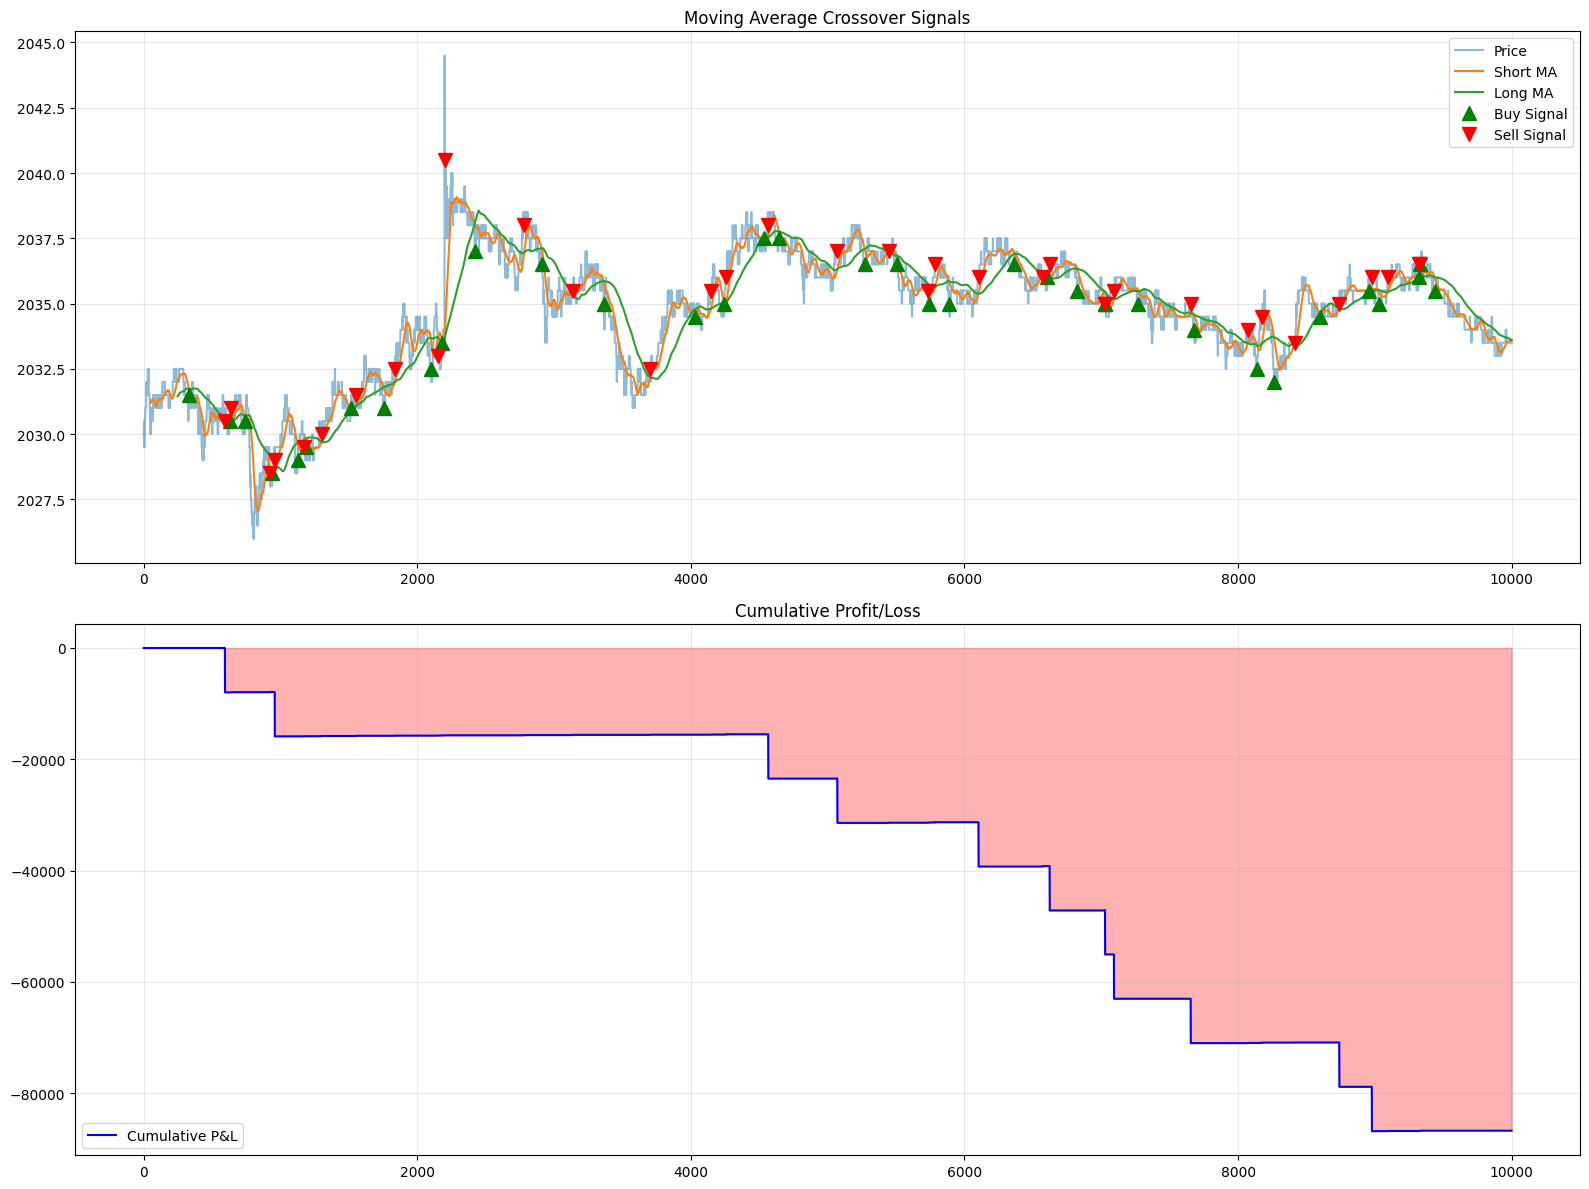

In [26]:
trade_volume = 1

# Convert to pandas Series if it's not already

price_series = pd.Series(price)

window_short = 50
window_long = 250

# Calculate Simple Moving Averages with different window sizes
sma_short = price_series.rolling(window=window_short).mean()
sma_long = price_series.rolling(window=window_long).mean()

# Create signals based on SMA crossovers
signals = pd.DataFrame(index=price_series.index)

signals['price'] = price_series
signals['bid_price_1'] = bp1
signals['ask_price_1'] = ap1
signals['short_ma'] = sma_short
signals['long_ma'] = sma_long
signals['signal'] = 0.0

# Create buy/sell signals when short MA crosses long MA
signals.loc[window_long:, 'signal'] = np.where(signals.loc[window_long:, 'short_ma'] < signals.loc[window_long:, 'long_ma'], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

# Initialize columns to track trades and performance
signals['trade_price'] = np.nan
signals['trade_type'] = ''
signals['profit_loss'] = np.nan
signals['cumulative_pl'] = 0.0

# Track whether we're in a position and the entry price
in_position = False
entry_price = 0
entry_idx = None
total_profit_loss = 0

# Track entry and exit pairs
entries = []
exits = []

# Loop through the signals to identify complete trades
for i in range(len(signals)):
    current_idx = signals.index[i]
    
    # Buy signal
    if signals['positions'].iloc[i] == 1.0:
        signals.loc[current_idx, 'trade_price'] = signals.loc[current_idx, 'price']
        signals.loc[current_idx, 'trade_type'] = 'BUY'
        entry_price = signals.loc[current_idx, 'ask_price_1']
    
        entry_idx = current_idx
        in_position = True
    
    # Sell signal
    elif signals['positions'].iloc[i] == -1.0:
        if in_position:
            exit_price = signals.loc[current_idx, 'price']
            profit_loss = exit_price - entry_price
            signals.loc[current_idx, 'bid_price_1'] = exit_price
            signals.loc[current_idx, 'trade_type'] = 'SELL'
            signals.loc[current_idx, 'profit_loss'] = profit_loss
            total_profit_loss += profit_loss
            
            # Store the paired entry and exit timestamps
            entries.append(entry_idx)
            exits.append(current_idx)
            
            in_position = False
    
    signals.loc[current_idx, 'cumulative_pl'] = total_profit_loss

# Create a summary of completed trades
completed_trades = signals[signals['profit_loss'].notna()]
profits = []
for entry_idx, exit_idx in zip(entries, exits):
    entry_price = signals.loc[entry_idx, 'price']
    exit_price = signals.loc[exit_idx, 'price']
    profit = exit_price - entry_price
    profits.append(profit)

trade_summary = pd.DataFrame({
    'Entry Time': entries,
    'Exit Time': exits,
    'Entry Price': [signals.loc[idx, 'price'] for idx in entries],
    'Exit Price': [signals.loc[idx, 'price'] for idx in exits],
    'Profit/Loss': profits
})

# Print performance metrics
num_trades = len(profits)
win_trades = sum(1 for p in profits if p > 0)
lose_trades = sum(1 for p in profits if p < 0)
win_rate = (win_trades / num_trades * 100) if num_trades > 0 else 0
avg_profit = sum(profits) / num_trades if num_trades > 0 else 0
max_profit = max(profits) if profits else 0
max_loss = min(profits) if profits else 0

print(f"Total Trades: {num_trades}")
print(f"Winning Trades: {win_trades} ({win_rate:.2f}%)")
print(f"Losing Trades: {lose_trades}")
print(f"Total P&L: {total_profit_loss:.2f}")
print(f"Average P&L per Trade: {avg_profit:.2f}")
print(f"Maximum Profit: {max_profit:.2f}")
print(f"Maximum Loss: {max_loss:.2f}")

# Add a visualization of the trades
plt.figure(figsize=(16, 12))

# Plot 1: Price and MAs with buy/sell signals
plt.subplot(2, 1, 1)
plt.plot(signals['price'], label='Price', alpha=0.5)
plt.plot(signals['short_ma'], label='Short MA')
plt.plot(signals['long_ma'], label='Long MA')

# Plot buy signals
plt.plot(signals.loc[signals['positions'] == 1.0].index, 
         signals.loc[signals['positions'] == 1.0]['price'],
         '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
plt.plot(signals.loc[signals['positions'] == -1.0].index, 
         signals.loc[signals['positions'] == -1.0]['price'],
         'v', markersize=10, color='r', label='Sell Signal')

plt.legend()
plt.title('Moving Average Crossover Signals')
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative P&L
plt.subplot(2, 1, 2)
plt.plot(signals.index, signals['cumulative_pl'], color='blue', label='Cumulative P&L')
plt.fill_between(signals.index, signals['cumulative_pl'], 0, 
                 where=(signals['cumulative_pl'] >= 0), color='green', alpha=0.3)
plt.fill_between(signals.index, signals['cumulative_pl'], 0, 
                 where=(signals['cumulative_pl'] < 0), color='red', alpha=0.3)
plt.legend()
plt.title('Cumulative Profit/Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()